In [2]:
using PyPlot
using LinearAlgebra
using JuMP
using Ipopt
using Statistics
using RandomMatrices
using BirkhoffDecomposition
using Permutations

In [3]:
function rowsum(A) #Returns a column vector containing the row sums of square matrix A
    m = size(A,1)
    rowsum = zeros(m,1)
    for i in 1:m
        rowsum[i] = sum(A[i,:])
    end
    return rowsum
end
####################################
function colsum(A) #Returns a column vector containing the column sums of square matrix A
    n = size(A,2)
    colsum = zeros(n,1)
    for i in 1:n
        colsum[i] = sum(A[:,i])
    end
    return colsum
end
####################################
function rs_ize(A) #Returns a row stochastic matrix, given a nonnegative matrix A
    rsA = rowsum(A)
    A = inv(diagm(vec(rsA)))*A  #A is row stochastic
    return A
end
####################################
# Φ cal with sigmoid
function Φ(dif,F,W)
    sig1 = 1-(1+exp(F*(dif+W)))^(-1)
    sig2 = (1+exp(F*(dif-W))).^(-1)
    return sig1 .* sig2
end
######################################
# HK model (for update)
function HK_update(A,x_os_up,F,W)
    N_a = size(A,2)
    xup = zeros(N_a,1)
    confi = 0;
    update = 0;
    for i in 1:N_a
        confi = sum(A[i,j]*Φ(x_os_up[j,1]-x_os_up[i,1],F,W) for j in 1:N_a)
        update = sum(A[i,j]*(Φ(x_os_up[j,1]-x_os_up[i,1],F,W)*(x_os_up[j,1]-x_os_up[i,1])) for j in 1:N_a)
        xup[i,1] = x_os_up[i,1] + (1/confi)*(update)
        update = 0
        confi = 0
    end 
    return xup
end
###################################
#Projection of vector x_os onto the hypercube [-1,1]^n
function hyp_proj(x_os)
    for i in 1:length(x_os)
        if x_os[i] >= 1
            x_os[i] = 1
        end
        if x_os[i] <= -1
            x_os[i] = -1
        end
    end
    return x_os
end
####################################
#Control of opinion dynamics control in social network
####################################
#COD = controlled opinion dynamics
#OSA = one step ahead
#x_os = current state 
#targ = vector of targets for 1 player
#b = input coupling vector for 1 player
#This function is set up to update agent states under the action of one player
#Written for the case of one player at a time, OSA, Gauss-Seidel updates
function COD_OSA_J_DeGroot(x_init,player_targets,γ,K_f,A,B,N_a,N_p,proj_flag)
#Initialize arrays
    #N_a = length(x_init) #Number of agents
    #N_p = length(player_targets) #Number of players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    temp = zeros(N_a,1)        #Temporary vector to projection  
    for k in 1:K_f #Time loop
            for p in 1:N_p #player loop
            
                #Name the model, define the solver and set its attributes
                S = "$p"
                S = Model(Ipopt.Optimizer)
                set_optimizer_attributes(S, "print_level" => 0 )
            
                #Define the optimization variables
                @variable(S, v) #v is the scalar value of the control for player p
                @variable(S, xn[1:N_a,1:1]) #xn is the new state of agent influenced by p
            
                #Define the control constraints
                #@constraint(S, u_min <= v <= u_max)
            
                #Define the dynamical constraint
                @constraint(S, xn .== A*x_os[:,k] + B[:,p]*v)
                #@constraint(S, 0 .<= xn .<= 1 )
                #Define the objective function for each agent
                @objective(S, Min, sum((xn - player_targets[:,p]).^2) + γ[p]*v*v)
            
                optimize!(S)
            
                #Retrieve optimal values for k-th iteration (instant)
                u_os[p,k] = JuMP.value.(S[:v])
            end
        temp[:,1] = A*x_os[:,k] + B*u_os[:,k]
        
        if proj_flag == 1
            x_os[:,k+1] = hyp_proj(temp[:,1])
        else
            x_os[:,k+1] = temp[:,1]
        end
    end
    return x_os, u_os
end
############################################################
#COD = controlled opinion dynamics, J = Jacobi information exchange; targets for players are specified
function COD_OSA_J_targets_FJ(x_init,player_targets,γ,K_f,A,B,Θ,N_a,N_p,proj_flag)
#Initialize arrays
    #N_a = length(x_init) #Number of agents
    #N_p = length(player_targets) #Number of players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    temp = zeros(N_a,1)        #Temporary vector to projection  
    for k in 1:K_f #Time loop
            for p in 1:N_p #player loop
            
                #Name the model, define the solver and set its attributes
                S = "$p"
                S = Model(Ipopt.Optimizer)
                set_optimizer_attributes(S, "print_level" => 0 )
            
                #Define the optimization variables
                @variable(S, v) #v is the scalar value of the control for player p
                @variable(S, xn[1:N_a,1:1]) #xn is the new state of agent influenced by p
            
                #Define the control constraints
                #@constraint(S, u_min <= v <= u_max)
            
                #Define the dynamical constraint
                @constraint(S, xn .== A*x_os[:,k] + Θ*x_init + B[:,p]*v)
                #@constraint(S, 0 .<= xn .<= 1 )
                #Define the objective function for each agent
                @objective(S, Min, sum((xn - player_targets[:,p]).^2) + γ[p]*v*v)
            
                optimize!(S)
            
                #Retrieve optimal values for k-th iteration (instant)
                u_os[p,k] = JuMP.value.(S[:v])
            end
        temp[:,1] = A*x_os[:,k] + Θ*x_init + B*u_os[:,k]
        
        if proj_flag == 1
            x_os[:,k+1] = hyp_proj(temp[:,1])
        else
            x_os[:,k+1] = temp[:,1]
        end
    end
    return x_os, u_os
end

############################################################
# HK with control using Jacobi update
function COD_OSA_J_targets_HK(x_init,targets,γ,K_f,A,B,u_min,u_max,F,W,flag_proj)
    #Initialize arrays
    N_a = size(A,1)
    N_p = size(B,2)
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    x_os[:,1] = x_init         #Initial states (opinions) of each 
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls    
    
    for k in 1:K_f #Time loop
            for p in 1:N_p #player loop
                #Name the model, define the solver and set its attributes
                S = "$p"
                S = Model(Ipopt.Optimizer)
                set_optimizer_attributes(S, "print_level" => 0 )
            
                #Define the optimization variables
                @variable(S, v) #v is the scalar value of the control for player p
                @variable(S, xn[1:N_a,1:1]) #xn is the new state of agent influenced by p
            
                #Define the control constraints
                @constraint(S, u_min <= v <= u_max)
            
                #Define the dynamical constraint
                @constraint(S, xn .== HK_update(A,x_os[:,k],F,W) + B[:,p]*v)
                #@constraint(S, 0 .<= xn .<= 1 ) #Restrição nas opiniões
                #Define the objective function for each agent
                @objective(S, Min, sum((xn - targets[:,p]).^2) + γ[p]*v*v)
            
                optimize!(S)
            
                #Retrieve optimal values for k-th iteration (instant)
                u_os[p,k] = JuMP.value.(S[:v])
            end
        
        x_int = HK_update(A,x_os[:,k],F,W) + B*u_os[:,k]
        
        if flag_proj == 1
            x_os[:,k+1] = hyp_proj(x_int)
        else
            x_os[:,k+1] = x_int
        end
    end
    
    return x_os, u_os
end
############################################################

function plot_opinions(x_os,N)
    figure(figsize=(6,6))
    grid()
    for i in 1:size(x_os,1)
        plot(x_os[i,1:N],".-")
    end
#=
plot(x1_hat_4.*ones(K_f_4,1),"--",color = "blue");
plot(x2_hat_4.*ones(K_f_4,1),"--",color = "darkorange");
plot(x3_hat_4.*ones(K_f_4,1),"--",color = "green");
=#
    xlabel("Time")
    ylabel("Opinions \$x_i\$, \$i=1,...,5\$")
    #legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5"],loc="best")
    legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"x_6",L"x_7", L"x_8", L"x_9", L"x_{10}"],loc="best")
    title("Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.")
end

plot_opinions (generic function with 1 method)

# Sec 4.1 Example of Social Network with 10 Agents and 4 Players

In [4]:
#Agents initial conditions
N_a_1 =  10 #number of agents
#x_init_1 = rand(N_a_1) 
#x_init_1 = [0.5;0.7; 0.4; 0.4; 0.8; 0.7; 0.9; 0.6; 0.3; 0.5]
x_init_1 = [0.1;0.7; 0.4; 0.4; 0.8; 0.7; 0.9; 0.6; 0.9; 0.5]


#Players targets
N_p_1 = 4
x1_hat_1 = 0.5
x2_hat_1 = 0.7
x3_hat_1 = 0.2
x4_hat_1 = 0.3

p1 = [x1_hat_1;0;0;0;0;0;0;0;0;0]
p2 = [0;0;0;x2_hat_1;0;0;0;0;0;0]
p3 = [0;0;0;0;0;x3_hat_1;0;0;0;0]
p4 = [0;0;0;0;0;0;0;0;x4_hat_1;0]

targets_1 = [p1 p2 p3 p4]
#γ_1 = 0.1*rand(size(targets_1,1))
γ_1 = [0.01; 0.01; 0.01;0.01];
#println("Gamma = ", γ_1[1:N_p_1]);

#Dynamics
#DeGroot model
#A_1 = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.6 0.1 0.1 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.2 0.1 0.1 0.4];
A_1 = 1/N_a_1.*ones(N_a_1,N_a_1);
B_1 = [1 0 0 0; 0 0 0 0; 0 0 0 0; 0 1 0 0; 0 0 0 0; 0 0 1 0;  0 0 0 0; 0 0 0 0; 0 0 0 1;  0 0 0 0];

#Friedkin-Johnsen model
#Θ_1 = diagm([0.8,0.2,0.4,0,0.8])
#A_FJ_1 = (I(N_a_1)-Θ_1)*A_1;

#Hegselmann-Krause model

K_f_1 = 20; #horizon

In [5]:
x_os_1, u_os_1 = COD_OSA_J_DeGroot(x_init_1,targets_1,γ_1,K_f_1,A_1,B_1,N_a_1,N_p_1,0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


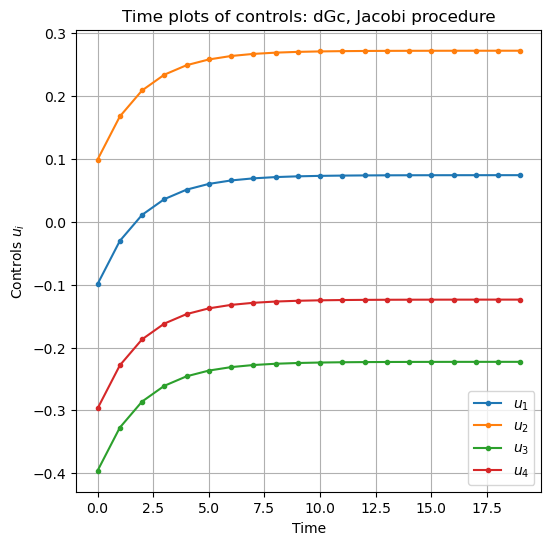

In [11]:
figure(figsize=(6,6))
grid()
for i in 1:size(u_os_1,1)
    plot(u_os_1[i,1:K_f_1],".-")
end

#plot(x1_hat_1.*ones(K_f_1,1),"--",color = "blue");
#plot(x2_hat_1.*ones(K_f_1,1),"--",color = "darkorange");
#plot(x3_hat_1.*ones(K_f_1,1),"--",color = "green");
#plot(x4_hat_1.*ones(K_f_1,1),"--",color = "darkred");

xlabel("Time")
ylabel("Controls \$u_i\$")
#legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"x_6",L"x_7",L"x_8",L"x_9",L"x_{10}",],loc="right")
legend([L"u_1",L"u_2", L"u_3", L"u_4"],loc="best")
title("Time plots of controls: dGc, Jacobi procedure")
savefig("DeGroot_Jacobi_Mazalov_controls.png")
savefig("DeGroot_Jacobi_Mazalov_controls.eps")

# Sec 7; Example 2 (4 agents and 2 players)

In [53]:
#Agents initial conditions
N_a_2 =  4 #number of agents
#x_init_1 = rand(N_a_1) 
x_init_2 = [0.7; 0.4; 0.4; 0.4]


#Players targets
N_p_2 = 2
x1_hat_2 = 0.8
x2_hat_2 = 0.5

p1 = [x1_hat_2;0;0;0]
p2 = [0;x2_hat_2;0;0]

targets_2 = [p1 p2]
#γ_1 = 0.1*rand(size(targets_1,1))
γ_2 = [0.1; 0.15];
#println("Gamma = ", γ_1[1:N_p_1]);

#Dynamics
#DeGroot model
A_2 = [0.55 0.15 0.15 0.15; 0.2 0.4 0.2 0.2; 0.2 0.2 0.4 0.2; 0.2 0.2 0.2 0.4]
B_2 = [1 0; 0 1; 0 0; 0 0];

K_f_2 = 20; #horizon

In [54]:
x_os_2, u_os_2 = COD_OSA_J_DeGroot(x_init_2,targets_2,γ_2,K_f_2,A_2,B_2,N_a_2,N_p_2,0);

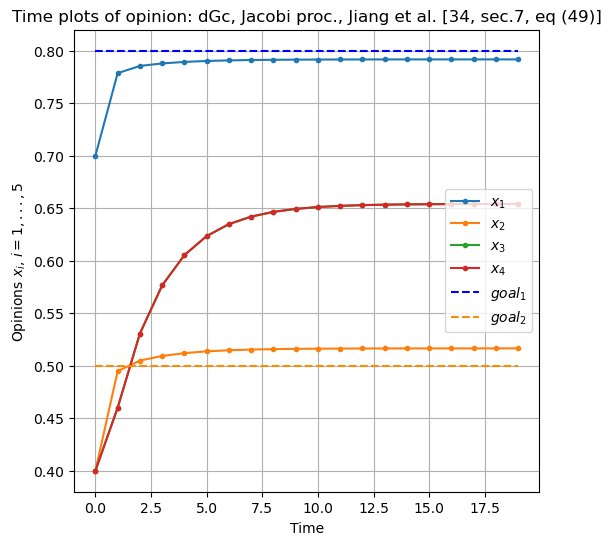

PyObject Text(0.5, 1.0, 'Time plots of opinion: dGc, Jacobi proc., Jiang et al. [34, sec.7, eq (49)]')

In [55]:
figure(figsize=(6,6))
grid()
for i in 1:size(x_os_2,1)
    plot(x_os_2[i,1:K_f_1],".-")
end

plot(x1_hat_2.*ones(K_f_1,1),"--",color = "blue");
plot(x2_hat_2.*ones(K_f_1,1),"--",color = "darkorange");
#plot(x3_hat_1.*ones(K_f_1,1),"--",color = "green");
#plot(x4_hat_1.*ones(K_f_1,1),"--",color = "darkred");

xlabel("Time")
ylabel("Opinions \$x_i\$, \$i=1,...,5\$")
legend([L"x_1",L"x_2", L"x_3", L"x_4", L"goal_1",L"goal_2"],loc="right")
title("Time plots of opinion: dGc, Jacobi proc., Jiang et al. [34, sec.7, eq (49)]")
#savefig("DeGroot_Jacobi_Mazalov_ex2.png")
#savefig("DeGroot_Jacobi_Mazalov_ex2.eps")

In [44]:
x_os_2[:,end]

4-element Vector{Float64}:
 0.7917416951485187
 0.5165110835511612
 0.6540995754757113
 0.6540995754757113